In [205]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from glob import glob
from scipy import optimize
from scipy.integrate import quad
from scipy.stats import norm
from math import erf
from math import tanh

In [311]:
def get_sigma_i_old(w,gal):
    muse_res_wav=np.array([4650,5000,5500,6000,6500,7000,7500,8000,8500,9000,9350])
    muse_res=np.array([1609,1750,1978,2227,2484,2737,2975,3183,3350,3465,3506])
    muse_res_err=np.array([6,4,6,6,5,4,4,4,4,5,10])
    
    h=pf.open(glob(gal+"/ADP*fits")[0])[0].header
    ref_res=h['SPEC_RES']
    ref_wav=(h['WAVELMIN']+h["WAVELMAX"])/2. * 10.
    
    ind=np.argmin(np.abs(w-muse_res_wav))
    ref_ind=np.argmin(np.abs(ref_wav-muse_res_wav))
    
    R=0
    dR=0
    if muse_res_wav[ind]-w > 0:
        width = muse_res_wav[ind] - muse_res_wav[ind-1]
        right = np.abs(muse_res_wav[ind]-w)/width
        left = np.abs(muse_res_wav[ind-1]-w)/width
        R+=np.average(np.array([muse_res[ind],muse_res[ind-1]]),weights=np.array([1/right,1/left]))
        dR+=np.average(np.array([muse_res_err[ind],muse_res_err[ind-1]]),weights=np.array([1/right,1/left]))
    elif muse_res_wav[ind]-w < 0:
        width=muse_res_wav[ind+1] - muse_res_wav[ind] 
        right = np.abs(muse_res_wav[ind+1]-w)/width
        left = np.abs(muse_res_wav[ind]-w)/width
        R+=np.average(np.array([muse_res[ind+1],muse_res[ind]]),weights=np.array([1/right,1/left]))
        dR+=np.average(np.array([muse_res_err[ind+1],muse_res_err[ind]]),weights=np.array([1/right,1/left])) 
    elif muse_res_wav[ind]-w==0:
        R+=muse_res[ind]
        dR+=muse_res_err[ind]
        
        
    R_ref=0
    dR_ref=0
    if muse_res_wav[ref_ind]-ref_wav > 0:
        width = muse_res_wav[ref_ind] - muse_res_wav[ref_ind-1]
        right = np.abs(muse_res_wav[ref_ind]-ref_wav)/width
        left = np.abs(muse_res_wav[ref_ind-1]-ref_wav)/width
        R_ref+=np.average(np.array([muse_res[ref_ind],muse_res[ref_ind-1]]),weights=np.array([1/right,1/left]))
        dR_ref+=np.average(np.array([muse_res_err[ref_ind],muse_res_err[ref_ind-1]]),weights=np.array([1/right,1/left]))
    elif muse_res_wav[ref_ind]-ref_wav < 0:
        width=muse_res_wav[ref_ind+1] - muse_res_wav[ref_ind] 
        right = np.abs(muse_res_wav[ref_ind+1]-ref_wav)/width
        left = np.abs(muse_res_wav[ref_ind]-ref_wav)/width
        R_ref+=np.average(np.array([muse_res[ref_ind+1],muse_res[ref_ind]]),weights=np.array([1/right,1/left]))
        dR_ref+=np.average(np.array([muse_res_err[ref_ind+1],muse_res_err[ref_ind]]),weights=np.array([1/right,1/left])) 
    elif muse_res_wav[ref_ind]-ref_wav==0:
        R_ref+=muse_res[ref_ind]
        dR_ref+=muse_res_err[ref_ind]
        
    delta=ref_res-R_ref
    
    R+=delta

    sigma=3e5/(R*(2*np.sqrt(2*np.log(2))))
    d_sigma=sigma* (dR/R)
    
    fwhm = sigma*(2*np.sqrt(2*np.log(2)))*w/3e5

    return fwhm

In [296]:
def gauss(x,a,x0,sig,c):

    return (np.abs(a) * np.exp(-(x - x0)**2 / (2 * sig**2))) + c

/Users/Hayley/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2.4944544413536217e-13 5.313591061190464e-08 -0.0008795797249112393 5.950769807470009
1.0648466187088158e-11 -1.8476689681360603e-07 0.0008914610564551618 1.600677462123877


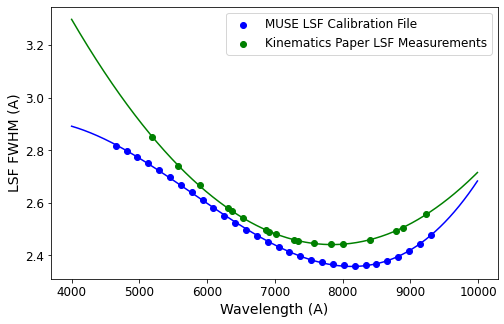

In [327]:
data=lsf[1].data
h=lsf[1].header
slice1=data[0]
x=np.arange(0,len(slice1))
w=4650 + (x*h["CD2_2"])

x=np.arange(0,150)
p=-7.5 + (x*h["CD1_1"])

fwhms=np.zeros_like(w)

for j in range(len(w)):
    fwhm_vals=[]
    for k in range(len(data)):
        slice_k=data[k]
        y=[slice_k[j][i] for i in x]
        popt,pcov=optimize.curve_fit(gauss,p,y,p0=[max(y),np.mean(p),2.5,0])
        fwhm=popt[2]*2*np.sqrt(2*np.log(2))
        fwhm_vals.append(fwhm)
    fwhms[j]=np.mean(fwhm_vals)
    
    
a,b,c,d=np.polyfit(w,fwhms,deg=3)

    
skyline_measurements=np.loadtxt("muse_res.csv")
w_kin=skyline_measurements[:,0]
fwhm_kin=skyline_measurements[:,1]

ak,bk,ck,dk=np.polyfit(w_kin,fwhm_kin,deg=3)


# muse=[get_sigma_i_old(i,"UGC9530") for i in w]
    
    
plt.figure(figsize=(8,5))

wplot=np.arange(4000,10000,10)
plt.scatter(w,fwhms,color='blue',label="MUSE LSF Calibration File")
plt.plot(wplot,a*wplot**3 + b*wplot**2 + c*wplot + d,color='blue')
plt.scatter(w_kin,fwhm_kin,color='green',label="Kinematics Paper LSF Measurements")
plt.plot(wplot,ak*wplot**3 + bk*wplot**2+ck*wplot+dk,color='green')
#plt.scatter(w,muse,color='red',label="FWHM From Header Resolution")


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Wavelength (A)",fontsize=14)
plt.ylabel("LSF FWHM (A)",fontsize=14)
plt.legend(fontsize=12)

print(ak,bk,ck,dk)
print(a,b,c,d)

cal_polyfit=np.array([a,b,c,d])
np.savetxt("muse_res_calibration.txt",cal_polyfit)

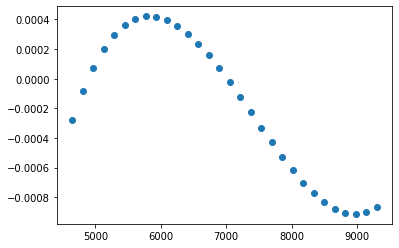

In [263]:
plt.scatter(w,y)

In [257]:
lsf=pf.open("lsf_profile_slow_wfm-noao-n.fits")
lsf[1].header


XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  150 / length of data axis 1                          
NAXIS2  =                   30 / length of data axis 2                          
NAXIS3  =                   48 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'CHAN01.LSF_PROFILE' / FITS Extension name                            
WCSAXES =                    2                                                  
CTYPE1  = 'PARAM   '                                                            
CTYPE2  = 'AWAV    '                                                            
CRVAL1  =                 -7

In [76]:
def get_sigma_i(w,instrument="MUSE"):
    
    if instrument=="MUSE":
        a,b,c=np.loadtxt("muse_res_polyfit.txt")
        fwhm=(a * w**2) + (b*w) + c #Angstroms
        sig=fwhm/(2*np.sqrt(2*np.log(2))) #Angstroms
        sigma_i = sig * (3e5) / w

#     if instrument=="MUSE":
#         gal='NGC2370'
#         muse_res_wav=np.array([4650,5000,5500,6000,6500,7000,7500,8000,8500,9000,9350])
#         muse_res=np.array([1609,1750,1978,2227,2484,2737,2975,3183,3350,3465,3506])
#         muse_res_err=np.array([6,4,6,6,5,4,4,4,4,5,10])

#         h=pf.open(glob(gal+"/ADP*fits")[0])[0].header
#         ref_res=h['SPEC_RES']
#         ref_wav=(h['WAVELMIN']+h["WAVELMAX"])/2. * 10.

#         ind=np.argmin(np.abs(w-muse_res_wav))
#         ref_ind=np.argmin(np.abs(ref_wav-muse_res_wav))

#         R=0
#         dR=0
#         if muse_res_wav[ind]-w > 0:
#             width = muse_res_wav[ind] - muse_res_wav[ind-1]
#             right = np.abs(muse_res_wav[ind]-w)/width
#             left = np.abs(muse_res_wav[ind-1]-w)/width
#             R+=np.average(np.array([muse_res[ind],muse_res[ind-1]]),weights=np.array([1/right,1/left]))
#             dR+=np.average(np.array([muse_res_err[ind],muse_res_err[ind-1]]),weights=np.array([1/right,1/left]))
#         elif muse_res_wav[ind]-w < 0:
#             width=muse_res_wav[ind+1] - muse_res_wav[ind] 
#             right = np.abs(muse_res_wav[ind+1]-w)/width
#             left = np.abs(muse_res_wav[ind]-w)/width
#             R+=np.average(np.array([muse_res[ind+1],muse_res[ind]]),weights=np.array([1/right,1/left]))
#             dR+=np.average(np.array([muse_res_err[ind+1],muse_res_err[ind]]),weights=np.array([1/right,1/left])) 
#         elif muse_res_wav[ind]-w==0:
#             R+=muse_res[ind]
#             dR+=muse_res_err[ind]


#         R_ref=0
#         dR_ref=0
#         if muse_res_wav[ref_ind]-ref_wav > 0:
#             width = muse_res_wav[ref_ind] - muse_res_wav[ref_ind-1]
#             right = np.abs(muse_res_wav[ref_ind]-ref_wav)/width
#             left = np.abs(muse_res_wav[ref_ind-1]-ref_wav)/width
#             R_ref+=np.average(np.array([muse_res[ref_ind],muse_res[ref_ind-1]]),weights=np.array([1/right,1/left]))
#             dR_ref+=np.average(np.array([muse_res_err[ref_ind],muse_res_err[ref_ind-1]]),weights=np.array([1/right,1/left]))
#         elif muse_res_wav[ref_ind]-ref_wav < 0:
#             width=muse_res_wav[ref_ind+1] - muse_res_wav[ref_ind] 
#             right = np.abs(muse_res_wav[ref_ind+1]-ref_wav)/width
#             left = np.abs(muse_res_wav[ref_ind]-ref_wav)/width
#             R_ref+=np.average(np.array([muse_res[ref_ind+1],muse_res[ref_ind]]),weights=np.array([1/right,1/left]))
#             dR_ref+=np.average(np.array([muse_res_err[ref_ind+1],muse_res_err[ref_ind]]),weights=np.array([1/right,1/left])) 
#         elif muse_res_wav[ref_ind]-ref_wav==0:
#             R_ref+=muse_res[ref_ind]
#             dR_ref+=muse_res_err[ref_ind]

#         delta=ref_res-R_ref

#         R+=delta

#         sigma_i=3e5/(R*(2*np.sqrt(2*np.log(2))))

        
    elif instrument=="MOSFIRE":
        m,b=np.loadtxt("../calibrations/polyfitJ.txt")
        R=m*w + b
    
        sigma_i=(3e5)/R/(2*np.sqrt(2*np.log(2)))
        
    elif instrument=="MOSFIRE_convolved":
        a,b,c=np.loadtxt("muse_res_polyfit.txt")
        w=w/2.35
        fwhm=(a * w**2) + (b*w) + c #Angstroms
        sig=fwhm/(2*np.sqrt(2*np.log(2))) #Angstroms
        sigma_i = sig * (3e5) / w
        
    return sigma_i


In [175]:
def gaussian_cdf(x,A,x0,sig,c):
    width=1.25
    left=x-(1.25/2.)
    right=x+(1.25/2.)
    integrated=norm.cdf(right,loc=x0,scale=disp) - norm.cdf(left,loc=x0,scale=disp)
    return (integrated*A*disp*np.sqrt(2*np.pi)/width) +c
 
def gaussian_quad(x,A,x0,disp,c):

    width = 1.25#angstroms
    integrated_flux=np.zeros_like(x)

    for i in range(len(x)):

        left=x[i]-(width/2.)
        right=x[i]+(width/2.)

        integrated_flux[i]=(quad(Gauss,left,right,args=(A,x0,disp,0))[0])/width

    return integrated_flux + c

def gaussian_pdf(x,A,x0,disp):
    flux=norm.pdf(x,loc=x0,scale=disp)*A*np.sqrt(2*np.pi)
    

In [204]:
sig*np.sqrt(np.pi/2) *(erf((x0-0)/(np.sqrt(2)*sig)) - erf((x0-1.25)/(np.sqrt(2)*sig)))

1.1998130473997102

In [208]:
sig*np.sqrt(np.pi/2) *(tanh((x0-0)*np.sqrt(np.pi)*np.log(2)/(np.sqrt(2)*sig)) - tanh((x0-1.25)*np.sqrt(np.pi)*np.log(2)/(np.sqrt(2)*sig)))

1.2813984653488686

In [202]:
gaussian_cdf(1.25/2.,1,0,sig,0)*1.25

1.1998130473997104

In [191]:
x0=0

x=1.25/2.
sig=2.5

y1=norm.pdf(x,loc=x0,scale=sig)
y2=np.exp(-(x-x0)**2 / (2* sig**2 ))/np.sqrt(2*np.pi) /sig
y3=np.exp(-(x-x0)**2/(2*sig**2))

print(y1)
print(y2)
print(y3)

0.1546672467211397
0.1546672467211397
0.9692332344763441


12.533141373154933
12.533141373155


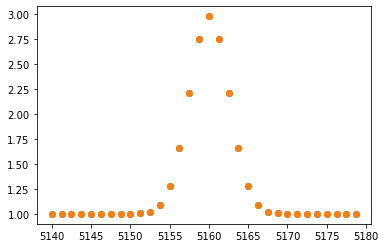

In [176]:
A=2
x0=5160
disp=2.5
c=1
x=np.arange(5140,5180,1.25)
y=gaussian_quad(x,A,x0,disp,c)
print(sum(y)*1.25 - (1.25*c*len(x)))
print(np.abs(A)*np.sqrt(2*np.pi)*np.abs(disp))
plt.scatter(x,y)
y2=gaussian_cdf(x,A,x0,disp,c)
plt.scatter(x,y2)

In [137]:
norm.pdf(5162,loc=5160,scale=2.5)*2


0.2317532422091862

In [138]:
Gauss(5162,2,5160,2.5,0)

1.4522980741473819

In [86]:
disp1=2.043/(2*np.sqrt(2*np.log(2)))
disp2=2.058/(2*np.sqrt(2*np.log(2)))
disp3=1.712/(2*np.sqrt(2*np.log(2)))

a1=20
a2=18
a3=110

x01=5157.5
x02=5162.5
x03=5160.5

def multi_gauss(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3,instrument="MUSE"):
    
    sig_i_1=get_sigma_i(x01,instrument)
    disp1=disp1*3e5/x01
    sig1=np.sqrt(disp1**2 + sig_i_1**2 )*x01/3e5

    sig_i_2=get_sigma_i(x02,instrument)
    disp2=disp2*3e5/x02
    sig2=np.sqrt(disp2**2 + sig_i_2**2 )*x02/3e5
    
    sig_i_3=get_sigma_i(x03,instrument)
    disp3=disp3*3e5/x03
    sig3=np.sqrt(disp3**2 + sig_i_3**2 )*x03/3e5


    return ((a1) * np.exp(-(x - x01)**2 / (2 * sig1**2)))+((a2) * np.exp(-(x - x02)**2 / (2 * sig2**2)))+((a3) * np.exp(-(x - x03)**2 / (2 * sig3**2)))

def multi_gaussian(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3):
    width = 1.25#angstroms
    integrated_flux=np.zeros_like(x)

    for i in range(len(x)):

        left=x[i]-(width/2.)
        right=x[i]+(width/2.)

        integrated_flux[i]=(quad(multi_gauss,left,right,args=(a1,a2,a3,x01,x02,x03,disp1,disp2,disp3))[0])/width

    return integrated_flux

def multi_gauss_mosfire(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3,instrument="MOSFIRE"):
    sig_i_1=get_sigma_i(x01,instrument)
    disp1=disp1*3e5/x01
    sig1=np.sqrt(disp1**2 + sig_i_1**2 )*x01/3e5

    sig_i_2=get_sigma_i(x02,instrument)
    disp2=disp2*3e5/x02
    sig2=np.sqrt(disp2**2 + sig_i_2**2 )*x02/3e5
    
    sig_i_3=get_sigma_i(x03,instrument)
    disp3=disp3*3e5/x03
    sig3=np.sqrt(disp3**2 + sig_i_3**2 )*x03/3e5


    return ((a1) * np.exp(-(x - x01)**2 / (2 * sig1**2)))+((a2) * np.exp(-(x - x02)**2 / (2 * sig2**2)))+((a3) * np.exp(-(x - x03)**2 / (2 * sig3**2)))

def multi_gaussian_mosfire(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3):
    width = 1.628959276018577#angstroms
    integrated_flux=np.zeros_like(x)

    for i in range(len(x)):

        left=x[i]-(width/2.)
        right=x[i]+(width/2.)

        integrated_flux[i]=(quad(multi_gauss_mosfire,left,right,args=(a1,a2,a3,x01,x02,x03,disp1,disp2,disp3))[0])/width

    return integrated_flux

def gauss(x,a,x0,disp,instrument="MUSE"):
    
    sig_i=get_sigma_i(x0,instrument) 
    disp=disp*3e5/x0
    sig=np.sqrt(disp**2 + sig_i**2 )*x0/3e5


    return (np.abs(a) * np.exp(-(x - x0)**2 / (2 * sig**2)))

def gauss_mosfire(x,a,x0,disp,instrument="MOSFIRE"):
    
    sig_i=get_sigma_i(x0,instrument) 
    disp=disp*3e5/x0
    sig=np.sqrt(disp**2 + sig_i**2 )*x0/3e5


    return (np.abs(a) * np.exp(-(x - x0)**2 / (2 * sig**2)))

def gauss_mosfire_convolved(x,a,x0,disp):
    
    sig_i = get_sigma_i(x0,"MOSFIRE_convolved")
    disp=disp*3e5/x0
    sig=np.sqrt(disp**2 + sig_i**2)*x0/3e5
    
    return (np.abs(a) * np.exp(-(x - x0)**2 / (2 * sig**2)))


def gaussian(x,a,x0,disp):

    width = 1.25#angstroms
    integrated_flux=np.zeros_like(x)

    for i in range(len(x)):

        left=x[i]-(width/2.)
        right=x[i]+(width/2.)

        integrated_flux[i]=(quad(gauss,left,right,args=(a,x0,disp))[0])/width

    return integrated_flux
    
def gaussian_mosfire(x,a,x0,disp):
    
    width=1.628959276018577
    
    integrated_flux=np.zeros_like(x)
    
    for i in range(len(x)):
        left=x[i]-(width/2.)
        right=x[i]+(width/2.)
        
        integrated_flux[i]=(quad(gauss_mosfire,left,right,args=(a,x0,disp))[0])/width
        
    return integrated_flux

def gaussian_mosfire_convolved(x,a,x0,disp):
    
    width=1.628959276018577
    
    integrated_flux=np.zeros_like(x)
    
    for i in range(len(x)):
        left=x[i]-(width/2.)
        right=x[i]+(width/2.)
        
        integrated_flux[i]=(quad(gauss_mosfire_convolved,left,right,args=(a,x0,disp))[0])/width
        
    return integrated_flux

In [85]:
        
def Gauss(x,a,x0,sig,c):

    return (np.abs(a) * np.exp(-(x - x0)**2 / (2 * sig**2))) + c

In [113]:
def convolve(wav,spec1d):

    m,b=np.loadtxt("../calibrations/polyfitJ.txt")
        
    muse_a,muse_b,muse_c=np.loadtxt("muse_res_polyfit.txt")

    spec1d_convolved=np.zeros_like(spec1d)

    for i,w in enumerate(wav):
        mos_res= m*w + b
        mos_sig= w/ mos_res /(2*np.sqrt(2*np.log(2)))
      
        muse_w= w /2.35
        muse_fwhm=(muse_a * muse_w**2) + (muse_b*muse_w) + muse_c #Angstroms
        muse_sig=muse_fwhm/(2*np.sqrt(2*np.log(2))) * 2.35 #Angstroms

        
        if i>50 and i<(len(wav) -51):
            kernel= np.sqrt(muse_sig**2 - mos_sig**2)
            vals=[]
            weights=[]
            for j in range(i-10,i+10):
                weights.append(Gauss(wav[j],1,wav[i],kernel,0))
                vals.append(spec1d[j])
    
            weights=np.array(weights)
            vals=np.array(vals)

            
            weights=weights/sum(weights)

            spec1d_convolved[i]=sum(vals*weights)
    return spec1d_convolved

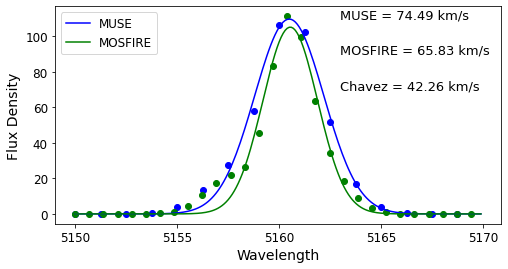

In [61]:
x=np.arange(5150,5170,1.25)
y=multi_gaussian(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3)

xmos=np.arange(5150*2.35,5170*2.35,1.628959276018577)
ymos=multi_gaussian_mosfire(xmos,a1,a2,a3,x01*2.35,x02*2.35,x03*2.35,disp1*2.35,disp2*2.35,disp3*2.35)

popt,pcov=optimize.curve_fit(gaussian,x,y,p0=[max(y),np.mean(x),5])

poptmos,pcovmos=optimize.curve_fit(gaussian_mosfire,xmos,ymos,p0=[max(ymos),np.mean(xmos),5])

xplot=np.arange(5150,5170,.1)
yplot=gaussian(xplot,*popt)
yplotmos=gaussian_mosfire(xplot*2.35,*poptmos)


plt.figure(figsize=(8,4))
plt.scatter(x,y,color='blue')
plt.scatter(xmos/2.35,ymos,color='green')
plt.plot(xplot,yplot,color='blue',label="MUSE")


plt.plot(xplot,yplotmos,color='green',label="MOSFIRE")

plt.xticks([5150,5155,5160,5165,5170],fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Wavelength",fontsize=14)
plt.ylabel("Flux Density",fontsize=14)

plt.text(5163,110,"MUSE = " +"%.2f"%(popt[2]*3e5/popt[1])+" km/s",fontsize=13)
plt.text(5163,90,"MOSFIRE = "+"%.2f"%(poptmos[2]*3e5/poptmos[1])+" km/s",fontsize=13)
plt.text(5163,70,"Chavez = "+"%.2f"%(1.712/(2*np.sqrt(2*np.log(2))) *3e5/5160.5)+" km/s",fontsize=13)

plt.legend(loc=2,fontsize=12)

plt.savefig('toy_model2.png')

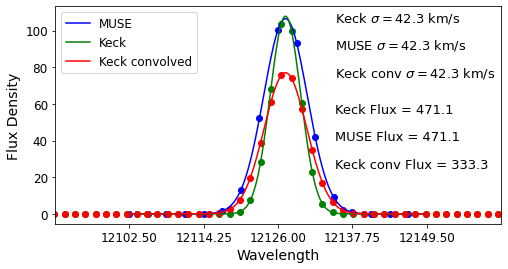

In [114]:
x=np.arange(5150,5170,1.25)
y=gaussian(x,a3,x03,disp3)

xmos=np.arange(5050*2.35,5270*2.35,1.628959276018577)
ymos=gaussian_mosfire(xmos,a3,x03*2.35,disp3*2.35)

ymos_convolved=convolve(xmos,ymos)

popt,pcov=optimize.curve_fit(gaussian,x,y,p0=[max(y),np.mean(x),5])

poptmos,pcovmos=optimize.curve_fit(gaussian_mosfire,xmos,ymos,p0=[max(ymos),np.mean(xmos),5])

poptmos_convolved,pcovmos_convolved=optimize.curve_fit(gaussian_mosfire_convolved,xmos,ymos_convolved,p0=[max(ymos_convolved),np.mean(xmos),5])

xplot=np.arange(5150*2.35,5170*2.35,.1)
yplot=gaussian(xplot/2.35,*popt)
yplotmos=gaussian_mosfire(xplot,*poptmos)
yplotmos_convolved=gaussian_mosfire_convolved(xplot,*poptmos_convolved)

plt.figure(figsize=(8,4))

plt.scatter(x*2.35,y,color='blue')
plt.scatter(xmos,ymos,color='green')
plt.scatter(xmos,ymos_convolved,color='red')

plt.plot(xplot,yplot,color='blue',label="MUSE")
plt.plot(xplot,yplotmos,color='green',label="Keck")
plt.plot(xplot,yplotmos_convolved,color='red',label="Keck convolved")

plt.xticks([5150*2.35,5155*2.35,5160*2.35,5165*2.35,5170*2.35],fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(5145*2.35,5175*2.35)

plt.xlabel("Wavelength",fontsize=14)
plt.ylabel("Flux Density",fontsize=14)


plt.text(12135,105,"Keck "+r"$\sigma=$"+"%.1f"%(poptmos[2]*3e5/poptmos[1])+" km/s",fontsize=13)
plt.text(12135,90,"MUSE "+r"$\sigma=$"+"%.1f"%(popt[2]*3e5/popt[1])+" km/s",fontsize=13)
plt.text(12135,75,"Keck conv "+r"$\sigma=$"+"%.1f"%(poptmos_convolved[2]*3e5/poptmos_convolved[1])+" km/s",fontsize=13)

muse_flux=np.abs(popt[0])*np.sqrt(2*np.pi)*np.abs(popt[2])*2.35
mos_flux=np.abs(poptmos[0])*np.sqrt(2*np.pi)*np.abs(poptmos[2])
mos_con_flux=np.abs(poptmos_convolved[0])*np.sqrt(2*np.pi)*np.abs(poptmos_convolved[2])

plt.text(12135,55,"Keck Flux = "+"%.1f"%mos_flux,fontsize=13)
plt.text(12135,40,"MUSE Flux = "+"%.1f"%muse_flux,fontsize=13)
plt.text(12135,25,"Keck conv Flux = "+"%.1f"%mos_con_flux,fontsize=13 )
plt.legend(loc=2,fontsize=12)

plt.savefig('toy_model4.png')

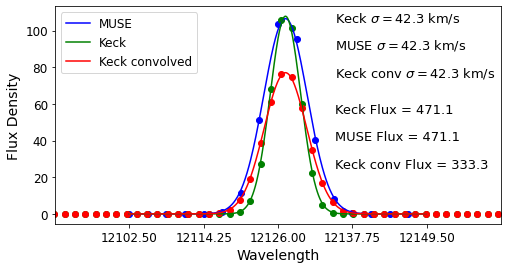

In [112]:
x=np.arange(5150,5170,1.25)
y=gauss(x,a3,x03,disp3)

xmos=np.arange(5050*2.35,5270*2.35,1.628959276018577)
ymos=gauss_mosfire(xmos,a3,x03*2.35,disp3*2.35)

ymos_convolved=convolve(xmos,ymos)

popt,pcov=optimize.curve_fit(gauss,x,y,p0=[max(y),np.mean(x),5])

poptmos,pcovmos=optimize.curve_fit(gauss_mosfire,xmos,ymos,p0=[max(ymos),np.mean(xmos),5])

poptmos_convolved,pcovmos_convolved=optimize.curve_fit(gauss_mosfire_convolved,xmos,ymos_convolved,p0=[max(ymos_convolved),np.mean(xmos),5])

xplot=np.arange(5150*2.35,5170*2.35,.1)
yplot=gaussian(xplot/2.35,*popt)
yplotmos=gaussian_mosfire(xplot,*poptmos)
yplotmos_convolved=gaussian_mosfire_convolved(xplot,*poptmos_convolved)

plt.figure(figsize=(8,4))

plt.scatter(x*2.35,y,color='blue')
plt.scatter(xmos,ymos,color='green')
plt.scatter(xmos,ymos_convolved,color='red')

plt.plot(xplot,yplot,color='blue',label="MUSE")
plt.plot(xplot,yplotmos,color='green',label="Keck")
plt.plot(xplot,yplotmos_convolved,color='red',label="Keck convolved")

plt.xticks([5150*2.35,5155*2.35,5160*2.35,5165*2.35,5170*2.35],fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(5145*2.35,5175*2.35)

plt.xlabel("Wavelength",fontsize=14)
plt.ylabel("Flux Density",fontsize=14)


plt.text(12135,105,"Keck "+r"$\sigma=$"+"%.1f"%(poptmos[2]*3e5/poptmos[1])+" km/s",fontsize=13)
plt.text(12135,90,"MUSE "+r"$\sigma=$"+"%.1f"%(popt[2]*3e5/popt[1])+" km/s",fontsize=13)
plt.text(12135,75,"Keck conv "+r"$\sigma=$"+"%.1f"%(poptmos_convolved[2]*3e5/poptmos_convolved[1])+" km/s",fontsize=13)

muse_flux=np.abs(popt[0])*np.sqrt(2*np.pi)*np.abs(popt[2])*2.35
mos_flux=np.abs(poptmos[0])*np.sqrt(2*np.pi)*np.abs(poptmos[2])
mos_con_flux=np.abs(poptmos_convolved[0])*np.sqrt(2*np.pi)*np.abs(poptmos_convolved[2])

plt.text(12135,55,"Keck Flux = "+"%.1f"%mos_flux,fontsize=13)
plt.text(12135,40,"MUSE Flux = "+"%.1f"%muse_flux,fontsize=13)
plt.text(12135,25,"Keck conv Flux = "+"%.1f"%mos_con_flux,fontsize=13 )
plt.legend(loc=2,fontsize=12)

plt.savefig('toy_model5.png')

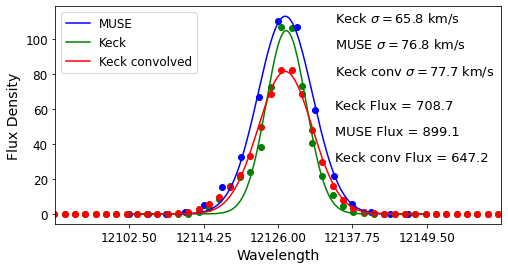

In [116]:
x=np.arange(5150,5170,1.25)
y=multi_gaussian(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3)

xmos=np.arange(5050*2.35,5270*2.35,1.628959276018577)
ymos=multi_gaussian_mosfire(xmos,a1,a2,a3,x01*2.35,x02*2.35,x03*2.35,disp1*2.35,disp2*2.35,disp3*2.35)

ymos_convolved=convolve(xmos,ymos)

popt,pcov=optimize.curve_fit(gaussian,x,y,p0=[max(y),np.mean(x),5])

poptmos,pcovmos=optimize.curve_fit(gaussian_mosfire,xmos,ymos,p0=[max(ymos),np.mean(xmos),5])

poptmos_convolved,pcovmos_convolved=optimize.curve_fit(gaussian_mosfire_convolved,xmos,ymos_convolved,p0=[max(ymos_convolved),np.mean(xmos),5])


xplot=np.arange(5150*2.35,5170*2.35,.1)
yplot=gaussian(xplot/2.35,*popt)
yplotmos=gaussian_mosfire(xplot,*poptmos)
yplotmos_convolved=gaussian_mosfire_convolved(xplot,*poptmos_convolved)

plt.figure(figsize=(8,4))

plt.scatter(x*2.35,y,color='blue')
plt.scatter(xmos,ymos,color='green')
plt.scatter(xmos,ymos_convolved,color='red')

plt.plot(xplot,yplot,color='blue',label="MUSE")
plt.plot(xplot,yplotmos,color='green',label="Keck")
plt.plot(xplot,yplotmos_convolved,color='red',label="Keck convolved")

plt.xticks([5150*2.35,5155*2.35,5160*2.35,5165*2.35,5170*2.35],fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(5145*2.35,5175*2.35)

plt.xlabel("Wavelength",fontsize=14)
plt.ylabel("Flux Density",fontsize=14)


plt.text(12135,110,"Keck "+r"$\sigma=$"+"%.1f"%(poptmos[2]*3e5/poptmos[1])+" km/s",fontsize=13)
plt.text(12135,95,"MUSE "+r"$\sigma=$"+"%.1f"%(popt[2]*3e5/popt[1])+" km/s",fontsize=13)
plt.text(12135,80,"Keck conv "+r"$\sigma=$"+"%.1f"%(poptmos_convolved[2]*3e5/poptmos_convolved[1])+" km/s",fontsize=13)

muse_flux=np.abs(popt[0])*np.sqrt(2*np.pi)*np.abs(popt[2])*2.35
mos_flux=np.abs(poptmos[0])*np.sqrt(2*np.pi)*np.abs(poptmos[2])
mos_con_flux=np.abs(poptmos_convolved[0])*np.sqrt(2*np.pi)*np.abs(poptmos_convolved[2])

plt.text(12135,60,"Keck Flux = "+"%.1f"%mos_flux,fontsize=13)
plt.text(12135,45,"MUSE Flux = "+"%.1f"%muse_flux,fontsize=13)
plt.text(12135,30,"Keck conv Flux = "+"%.1f"%mos_con_flux,fontsize=13 )
plt.legend(loc=2,fontsize=12)

plt.savefig('toy_model3.png')

MUSE = 73.27
MOSFIRE = 65.61
Chavez = 42.26


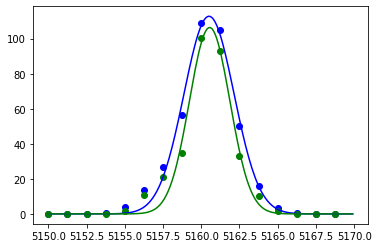

In [43]:
x=np.arange(5150,5170,1.25)
y=multi_gauss(x,a1,a2,a3,x01,x02,x03,disp1,disp2,disp3)

xmos=x*2.35
ymos=multi_gauss_mosfire(xmos,a1,a2,a3,x01*2.35,x02*2.35,x03*2.35,disp1*2.35,disp2*2.35,disp3*2.35)

plt.scatter(x,y,color='blue')
plt.scatter(xmos/2.35,ymos,color='green')

popt,pcov=optimize.curve_fit(gauss,x,y,p0=[max(y),np.mean(x),5])

poptmos,pcovmos=optimize.curve_fit(gauss_mosfire,xmos,ymos,p0=[max(ymos),np.mean(xmos),5])

xplot=np.arange(5150,5170,.1)
yplot=gauss(xplot,*popt)
plt.plot(xplot,yplot,color='blue',label="MUSE")

yplotmos=gauss_mosfire(xplot*2.35,*poptmos)
plt.plot(xplot,yplotmos,color='green',label="MOSFIRE")

print("MUSE = " +"%.2f"%(popt[2]*3e5/popt[1]))
print("MOSFIRE = "+"%.2f"%(poptmos[2]*3e5/poptmos[1]))
print("Chavez = "+"%.2f"%(1.712/(2*np.sqrt(2*np.log(2))) *3e5/5160.5))



In [40]:
def multi_gauss(x,f1,f2,x01,x02,disp1,disp2):
    
    gal="ASASSN-15fr"
    
    sig_i_1=get_sigma_i(x01,gal)[0] 
    sig1=np.sqrt(disp1**2 + sig_i_1**2 + 10.233 + 9.1**2)*x01/3e5

    sig_i_2=get_sigma_i(x02,gal)[0]
    sig2=np.sqrt(disp2**2 + sig_i_2**2 + 10.233 + 9.1**2)*x02/3e5

    a1=f1/(np.sqrt(2*np.pi))/np.abs(sig1)
    a2=f2/(np.sqrt(2*np.pi))/np.abs(sig2)

    return ((a1) * np.exp(-(x - x01)**2 / (2 * sig1**2)))+((a2) * np.exp(-(x - x02)**2 / (2 * sig2**2)))

def gauss(x,f,x0,disp):
    gal="ASASSN-15fr"
    
    sig_i=get_sigma_i(x0,gal)[0] 
    sig=np.sqrt(disp**2 + sig_i**2 + 10.233 + 9.1**2)*x0/3e5


    a=f/(np.sqrt(2*np.pi))/np.abs(sig)


    return ((a) * np.exp(-(x - x0)**2 / (2 * sig**2)))
    

In [53]:
f1=2e-15
f2=1e-15

x01=6780
x02=6782

disp1=50
disp2=25

def toy_model(f1,f2,x01,x02,disp1,disp2):

    sig1=disp1*x01/3e5
    sig2=disp2*x02/3e5

    a1=f1/(np.sqrt(2*np.pi))/np.abs(sig1)
    a2=f2/(np.sqrt(2*np.pi))/np.abs(sig2)

    x1=np.arange(x01-20,x01+20.1,.1)
    y1=((a1) * np.exp(-(x1 - x01)**2 / (2 * sig1**2)))

    x2=np.arange(x02-20,x02+20.1,.1)
    y2=((a2) * np.exp(-(x2 - x02)**2 / (2 * sig2**2)))

    fig,ax=plt.subplots(1,1,figsize=(8,5))

    ax.plot(x1,y1,color='green')
    ax.plot(x2,y2,color='blue')

    xdata=np.arange(np.mean([x01,x02])-20,np.mean([x01,x02])+21.25,1.25)
    ydata=multi_gauss(xdata,f1,f2,x01,x02,disp1,disp2)

    ax.scatter(xdata,ydata,color='k')

    popt,pcov=optimize.curve_fit(gauss,xdata,ydata,p0=[max(ydata),np.mean(xdata),40])

    xplot=np.arange(xdata[0],xdata[-1],.1)
    yplot=gauss(xplot,*popt)

    ax.plot(xplot,yplot,color='deeppink',ls='--')

    true_flux=(f1+f2)*1e15

    measured_flux=popt[0]*1e15

    true_disp=np.sqrt(disp1**2 + disp2**2)

    measured_disp=popt[2]

    ax.text(0.6,0.9,"True Flux = "+"%.2f"%true_flux,fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.text(0.6,0.8,"Measured Flux = "+"%.2f"%measured_flux,fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.text(0.6,0.6,"True Disp = "+"%.2f"%true_disp,fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.text(0.6,0.5,"Measured Disp = "+"%.2f"%measured_disp,fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax.text(0.05,0.9,"Component One",color='green',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.05,0.8,"Flux = "+"%.2f"%(f1*1e15),color='green',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.05,0.7,"Disp = "+"%.2f"%(disp1),color='green',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.05,0.6,"Center = "+"%.0f"%(x01),color='green',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)


    ax.text(0.05,0.45,"Component Two",color='blue',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.05,0.35,"Flux = "+"%.2f"%(f2*1e15),color='blue',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.05,0.25,"Disp = "+"%.2f"%(disp2),color='blue',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.05,0.15,"Center = "+"%.2f"%(x02),color='blue',fontsize=14,horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)


    ax.tick_params(labelsize=12)
    ax.set_xlabel("Wavelength",fontsize=14)
    ax.set_ylabel("Flux Density",fontsize=14)
    ax.set_title("Toy Gaussian Model",fontsize=16)

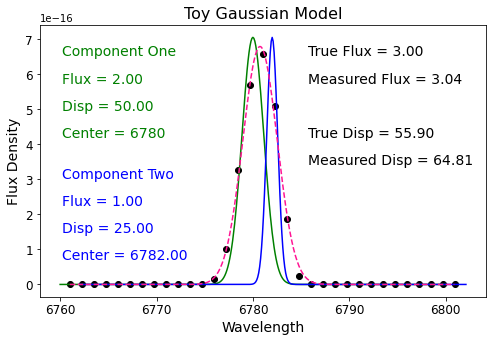

In [54]:
f1=2e-15
f2=1e-15

x01=6780
x02=6782

disp1=50
disp2=25

pars=[f1,f2,x01,x02,disp1,disp2]

toy_model(*pars)

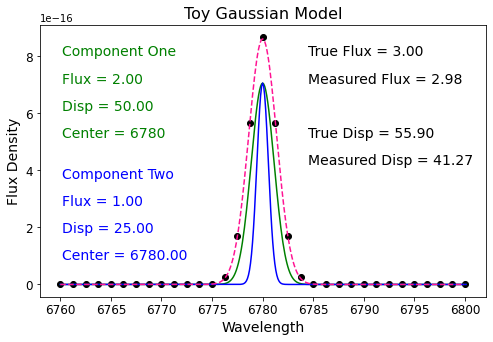

In [55]:
f1=2e-15
f2=1e-15

x01=6780
x02=6780

disp1=50
disp2=25

pars=[f1,f2,x01,x02,disp1,disp2]

toy_model(*pars)